In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import pickle
from datetime import datetime
from datetime import timezone
from scipy.stats import t
from mat4py import loadmat
from distfit import distfit

In [69]:
API_KEY = "b295fcc2-ae16-489d-9aa1-6368d8a23a44"
ENDPOINT = "https://dmigw.govcloud.dk/v2/metObs"
HEADER = {"X-Gravitee-Api-Key": API_KEY}

red = (0.77, 0, 0.05) # (196, 0, 13)
blue = (0.12, 0.24, 1) # (31, 61, 255)
green = (0.31, 1, 0.34) # (79, 255, 87)
navyblue = (0, 0, 0.4) # (0, 0, 102)
black = (0, 0, 0)
white = (1, 1, 1)

powerdata_path = r"./data/siemens/hourly_avg_wind_speed_and_power.mat"
pricedata_path = r"./data/siemens/da_price_data_dk1_10AM.csv"

powerdata_dict_list = loadmat(powerdata_path, meta=False)
pricedata = pd.read_csv(pricedata_path)
pricedata.dropna(inplace=True)
pricedata['error'] = pricedata['forecast'] - pricedata['nominal']

# Get data out of singleton lists
powerdata_dict = {}
for key in powerdata_dict_list.keys():
    powerdata_dict[key] = [l[0] for l in powerdata_dict_list[key]]
powerdata = pd.DataFrame(powerdata_dict)

# Features

In [26]:

df_DK2_2019 = pd.read_csv('./data/ENTSOE_Generation Forecasts for Wind and Solar_DK2_201901010000-202001010000.csv')
df_DK2_2020 = pd.read_csv('./data/ENTSOE_Generation Forecasts for Wind and Solar_DK2_202001010000-202101010000.csv')
df_DK2_2021 = pd.read_csv('./data/ENTSOE_Generation Forecasts for Wind and Solar_DK2_202101010000-202201010000.csv')

df_DK1_2019 = pd.read_csv('./data/ENTSOE_Generation Forecasts for Wind and Solar_DK1_201901010000-202001010000.csv')
df_DK1_2020 = pd.read_csv('./data/ENTSOE_Generation Forecasts for Wind and Solar_DK1_202001010000-202101010000.csv')
df_DK1_2021 = pd.read_csv('./data/ENTSOE_Generation Forecasts for Wind and Solar_DK1_202101010000-202201010000.csv')

df_r_2019 = pd.read_csv('./data/ENTSOE_Actual Generation Roedsand 2_201901010000-202001020000.csv')
df_r_2020 = pd.read_csv('./data/ENTSOE_Actual Generation Roedsand 2_202001010000-202101020000.csv')
df_r_2021 = pd.read_csv('./data/ENTSOE_Actual Generation Roedsand 2_202101010000-202201020000.csv')

In [70]:
dk1_list = [df_DK1_2019, df_DK1_2020, df_DK1_2021]
df_DK1 = pd.concat(dk1_list).reset_index()
dk2_list = [df_DK2_2019, df_DK2_2020, df_DK2_2021]
df_DK2 = pd.concat(dk2_list).reset_index()
df_r_list = [df_r_2019.dropna(subset=['MTU'], how='all')[:8760], df_r_2020.dropna(subset=['MTU'], how='all')[:(8760+24)], df_r_2021.dropna(subset=['MTU'], how='all')[:8760]]
df_r = pd.concat(df_r_list).reset_index()

df_DK1.set_index("MTU (CET/CEST)", inplace=True)
df_DK1 = df_DK1.loc[~df_DK1.index.duplicated(), :]

df_DK2.set_index("MTU (CET/CEST)", inplace=True)
df_DK2 = df_DK2.loc[~df_DK2.index.duplicated(), :]


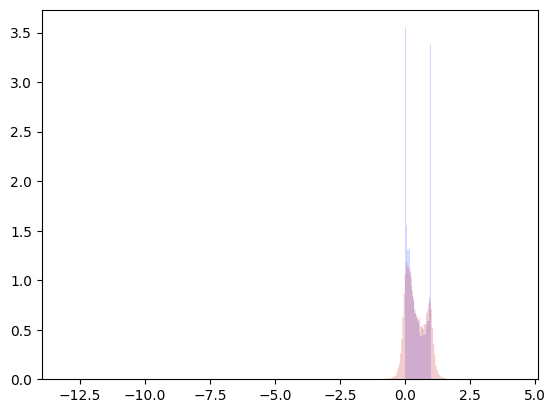

In [79]:
realized = df_r['Generation [MW]'].to_numpy().astype(float)
realized = realized / realized.max()
# Draw samples
# t_samples_power = t.rvs(3.3465, loc=-11.0358, scale=342.945, size=len(realized))
t_samples_power = t.rvs(3.3465, loc=-11.0358, scale=342.945, size=len(realized))

# Scale from 3 GW to 10 MW
t_samples_power *= np.max(realized)/3000

# forecast = []
# for i in range(len(realized)):
#     if realized[i] + t_samples_power[i] < 0 or realized[i] + t_samples_power[i] > np.max(realized):
#         forecast.append(realized[i] - t_samples_power[i])
#     else:
#         forecast.append(realized[i] + t_samples_power[i])

# forecast = np.minimum(np.maximum(realized + t_samples_power, 0), np.max(realized))
forecast = realized + t_samples_power
fig, ax = plt.subplots()
ax.hist(realized, density=True, bins='auto', histtype='stepfilled', alpha=0.2, color=blue)
ax.hist(forecast, density=True, bins='auto', histtype='stepfilled', alpha=0.2, color=red)
# ax.hist(errors, density=True, bins='auto', histtype='stepfilled', alpha=0.2, color="red")
fig.show()

In [86]:
powerdata['error_wp'].max()
# powerdata['hourly_avg_RE_wp'].max()

2215.4573194739937

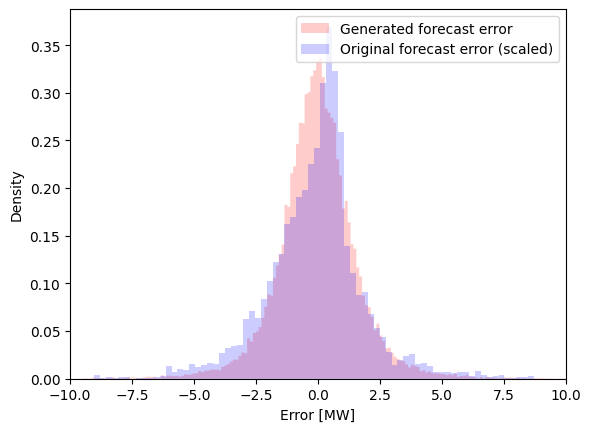

In [95]:
forecast_error = (forecast - realized)*10
powerdata['error_wp'] = powerdata['hourly_avg_FC_wp'] - powerdata['hourly_avg_RE_wp']

normalized_generated = forecast_error
normalized_original = powerdata['error_wp'] / powerdata['error_wp'].std() * forecast_error.std()
fig, ax = plt.subplots()
ax.hist(normalized_generated, density=True, bins='auto', color="red", histtype='stepfilled', alpha=0.2, label="Generated forecast error")
ax.hist(normalized_original, density=True, bins='auto', color="blue", histtype='stepfilled', alpha=0.2, label="Original forecast error (scaled)")
ax.legend()
ax.set_xlabel("Error [MW]")
ax.set_ylabel("Density")
ax.set_xlim(-10,10)
fig.show()
fig.savefig("production_forecast_error.pdf")

In [19]:
# df_forecasts = df_weather.copy()
df_forecasts = pd.DataFrame()
df_forecasts['realized'] = realized
df_forecasts['forecast'] = forecast
df_forecasts['offshore_DK2'] = df_DK2['Generation - Wind Offshore  [MW] Day Ahead/ BZN|DK2'].to_numpy().astype(float)
df_forecasts['offshore_DK1'] = df_DK1['Generation - Wind Offshore  [MW] Day Ahead/ BZN|DK1'].to_numpy().astype(float)
df_forecasts['onshore_DK2'] = df_DK2['Generation - Wind Onshore  [MW] Day Ahead/ BZN|DK2'].to_numpy().astype(float)
df_forecasts['onshore_DK1'] = df_DK1['Generation - Wind Onshore  [MW] Day Ahead/ BZN|DK1'].to_numpy().astype(float)
df_forecasts['solar_DK2'] = df_DK2['Generation - Solar  [MW] Day Ahead/ BZN|DK2'].to_numpy().astype(float)


df_forecasts.head()

,realized,forecast,offshore_DK2,offshore_DK1,onshore_DK2,onshore_DK1,solar_DK2
0,203.0,181.232983,253.0,586.0,551.0,2302.0,0.0
1,204.0,185.218116,328.0,627.0,645.0,2342.0,0.0
2,204.0,204.000000,257.0,254.0,590.0,2227.0,0.0
3,203.0,201.273133,210.0,233.0,566.0,2163.0,0.0
4,204.0,204.000000,204.0,233.0,559.0,2108.0,0.0


In [20]:

#--------Normalize for stability
for i in range(df_forecasts.shape[1]-1):
    df_forecasts.iloc[:, i] = df_forecasts.iloc[:, i] / df_forecasts.iloc[:, i].max()

df_forecasts.head()

,realized,forecast,offshore_DK2,offshore_DK1,onshore_DK2,onshore_DK1,solar_DK2
0,0.995098,0.888397,0.274701,0.506045,0.680247,0.659599,0.0
1,1.000000,0.907932,0.356135,0.541451,0.796296,0.671060,0.0
2,1.000000,1.000000,0.279045,0.219344,0.728395,0.638109,0.0
3,0.995098,0.986633,0.228013,0.201209,0.698765,0.619771,0.0
4,1.000000,1.000000,0.221498,0.201209,0.690123,0.604011,0.0


In [21]:
#----------Forecasts are noisy anyway, so skewing 1 hour is not detrimental
df_forecasts.fillna(method="ffill", inplace=True)
df_forecasts.isnull().values.any()
# df_forecasts['offshore_DK1'].isnull().values.any()
# df_forecasts['solar_DK2'].isnull().sum()

False

In [22]:
#-----------Final check
df_forecasts.shape

(26304, 7)

In [23]:
SAVE_AS_CSV = True
if (SAVE_AS_CSV):
    df_forecasts.to_csv('./data/features.csv')

# Prices

In [17]:
df_price_2019 = pd.read_csv('./data/ENTSOE_Day-ahead Prices_201901010000-202001010000.csv')
df_price_2020 = pd.read_csv('./data/ENTSOE_Day-ahead Prices_202001010000-202101010000.csv')
df_price_2021 = pd.read_csv('./data/ENTSOE_Day-ahead Prices_202101010000-202201010000.csv')
df_price_2019.dropna(subset=['Day-ahead Price [EUR/MWh]'], inplace=True)
df_price_2020.dropna(subset=['Day-ahead Price [EUR/MWh]'], inplace=True)
df_price_2021.dropna(subset=['Day-ahead Price [EUR/MWh]'], inplace=True)
df_price_2019.reset_index(inplace=True)
df_price_2020.reset_index(inplace=True)
df_price_2021.reset_index(inplace=True)


df_price = pd.DataFrame()
df_price["Forward"] = pd.concat([df_price_2019['Day-ahead Price [EUR/MWh]'], df_price_2020['Day-ahead Price [EUR/MWh]'], df_price_2021['Day-ahead Price [EUR/MWh]']])


df_price.reset_index(inplace=True, drop=True)
df_price.drop([24818], inplace=True)
df_price.loc[len(df_price.index)+1] = [46.6]
df_price.reset_index(inplace=True, drop=True)
df_price.to_csv('./data/forward.csv')

In [448]:
df_imbalance_2019 = pd.read_csv('./data/ENTSOE_Imbalance_201901010000-202001010000.csv')
df_imbalance_2020 = pd.read_csv('./data/ENTSOE_Imbalance_202001010000-202101010000.csv')
df_imbalance_2021_all = pd.read_csv('./data/remaining_balancing_data.csv', delimiter=";", decimal=",")

df_imbalance_2021_all['HourUTC'] = pd.to_datetime(df_imbalance_2021_all['HourUTC'], format='%Y-%m-%d %H:%M')
df_imbalance_2021_all.set_index("HourUTC", inplace=True)

#--------fix based on analysis
df_imbalance_2019["Generation / + Imbalance price [EUR/MWh] - MBA|DK2"][6826] = 30.43
df_imbalance_2019["Generation / - Imbalance price [EUR/MWh] - MBA|DK2"][6826] = 35.24
df_imbalance_2019.dropna(subset=['Generation / + Imbalance price [EUR/MWh] - MBA|DK2'], inplace=True)

df_imbalance_2020.dropna(subset=['Generation / + Imbalance price [EUR/MWh] - MBA|DK2'], inplace=True)

df_imbalance_2021_all = pd.concat([df_imbalance_2021_all, pd.Series(np.nan)])
df_imbalance_2021_all["BalancingPowerPriceDownEUR"][-1] = 46.60
df_imbalance_2021_all["BalancingPowerPriceUpEUR"][-1] = 46.60

df_imbalance_dw = pd.concat([df_imbalance_2019["Generation / + Imbalance price [EUR/MWh] - MBA|DK2"], df_imbalance_2020["Generation / + Imbalance price [EUR/MWh] - MBA|DK2"], df_imbalance_2021_all["BalancingPowerPriceDownEUR"]]).reset_index()
df_imbalance_up = pd.concat([df_imbalance_2019["Generation / - Imbalance price [EUR/MWh] - MBA|DK2"], df_imbalance_2020["Generation / - Imbalance price [EUR/MWh] - MBA|DK2"], df_imbalance_2021_all["BalancingPowerPriceUpEUR"]]).reset_index()

df_imbalance = pd.DataFrame({"Up": df_imbalance_up[0].to_numpy(), "Down": df_imbalance_dw[0].to_numpy(), "Forward": df_price["Forward"]})

df_imbalance['SinglePrice'] = np.where(df_imbalance['Up'] != df_imbalance['Forward'], df_imbalance['Up'], df_imbalance['Down'])

df_imbalance.head()


# df_imbalance['Single price'] = np.select(conditions, values)
# pd.date_range(start = '2021-01-01', end = '2022-01-01', freq="1h").difference(df_imbalance_2021_all.index)
df_imbalance.to_csv('./data/prices.csv')

C:\Users\emilh\AppData\Local\Temp\ipykernel_14416\2630855590.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imbalance_2019["Generation / + Imbalance price [EUR/MWh] - MBA|DK2"][6826] = 30.43
C:\Users\emilh\AppData\Local\Temp\ipykernel_14416\2630855590.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_imbalance_2019["Generation / - Imbalance price [EUR/MWh] - MBA|DK2"][6826] = 35.24
C:\Users\emilh\AppData\Local\Temp\ipykernel_14416\2630855590.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan